#### **Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 17 Nov**

1. Test on all Monday 24 hours data for Peachtree Street SB L2

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
dataset=dataset[dataset['date_time'].str.contains("2/25/2019")==False]
#check
print (dataset.iloc[49]['State-EB-L_1'])
#print (dataset.iloc[3359]['State-EB-L_1'])

-10.0


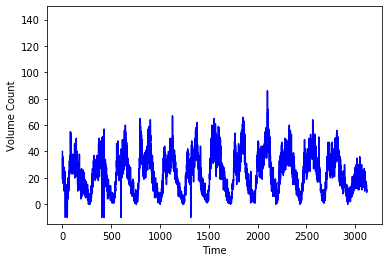

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_1 series 
series = dataset['Peachtree-SB-L_2'].values
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
plt.plot(time_num, series, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [5]:
num_days = 10
split_time = num_days*240
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
os.environ['PYTHONHASHSEED']=str(52)
tf.keras.backend.clear_session()
tf.random.set_seed(52)
np.random.seed(52)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 10.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=150, callbacks=[lr_schedule])


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('peachtree_sb_uni_l2.h5')


In [6]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('peachtree_sb_uni_l2.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 80)          33600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 80)          38720     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                28928     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

(-3.2, 120)

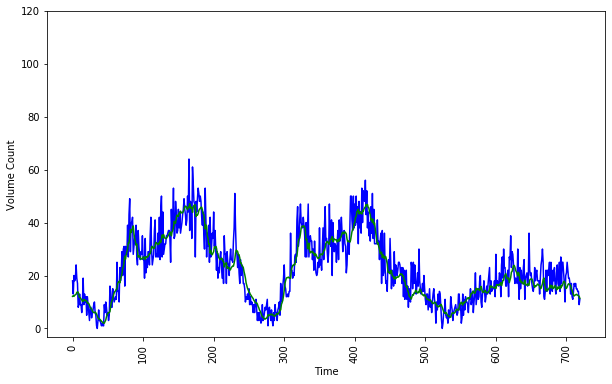

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(new_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
#print (forecast)
results = np.array(forecast)[:, 0, 0]
time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, results, color = 'green')
plt.ylim(top=120)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.579702

In [9]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

35.212257

In [10]:
# RMSE 
math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())


5.9339916906963985

In [11]:
#Forecast bias
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
#print (forecast_bias)

In [12]:
# Std. Dev. in Errors
np.std(array_of_errors)

5.881173698147154

In [13]:
#print (results)
mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 4.579702
mean squared error: 35.212257
root mean squared error: 5.9339916906963985
forecast_bias: 568.776923418045
standard dev of errors: 5.881173698147154


## One-step Forecasts for Typical Day

In [14]:
typical_actuals = x_valid[:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

mean absolute error: 4.879122
mean squared error: 39.164894
root mean squared error: 6.258186167253569
forecast_bias: 178.59803557395935
standard dev of errors: 6.247115066224803


(-3.2, 120)

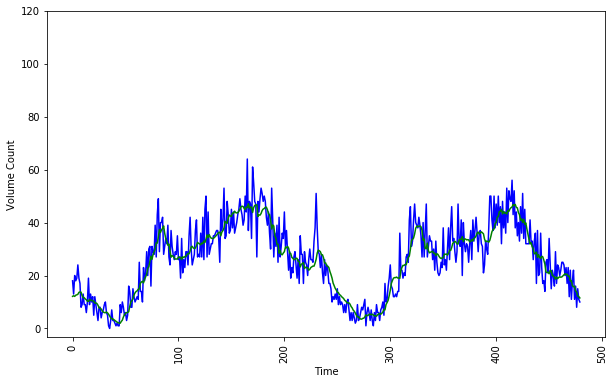

In [15]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## One-step Forecasts for Atypical Day

In [16]:
atypical_actuals = x_valid[-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


mean absolute error: 3.9808614
mean squared error: 27.306982
root mean squared error: 5.2256082938166415
forecast_bias: 390.1788878440857
standard dev of errors: 4.9662796000945235


(-1.8, 120)

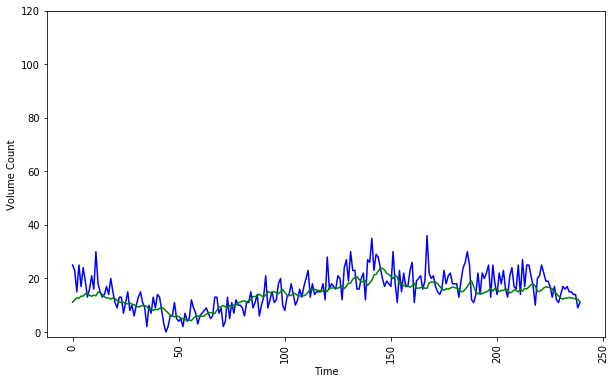

In [17]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
forecast = []
results = []

slice_val_time = 231
sliced_val_series = x_valid[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 120
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual-sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
actuals = sliced_val_actual[-120:]
predictions = sliced_val_series[-120:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals - predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Different Time Slice

In [ ]:
forecast = []
results = []
mae_array = []
rmse_array = []
std_array = []


for slice_val_time in range(100, 351,10):

    #slice_val_time = 100
    sliced_val_series = x_valid[:slice_val_time] 

    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    units_missing = 120
    for t in range(units_missing):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        sliced_val_series = np.append(sliced_val_series, forecast[-1])


    #forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    # print (results)
    # print (sliced_val_series)
    # plt.figure(figsize=(10, 6))
    # plt.xticks(rotation=90)

    sliced_val_actual = x_valid[:slice_val_time+units_missing] 
    sliced_val_times = time_valid[:slice_val_time+units_missing]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    actuals_slice = sliced_val_actual[-units_missing:]
    predictions_slice = sliced_val_series[-units_missing:]

    mae = tf.keras.metrics.mean_absolute_error(actuals_slice, predictions_slice).numpy()
    print ("mean absolute error: "+ str(mae))
    mae_array.append(mae)
    mse = tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy())
    print ("root mean squared error: "+ str(rmse))
    rmse_array.append(rmse)
    array_of_errors = (actuals_slice - predictions_slice)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    std_array.append(std_dev_errors)


In [ ]:
print (mae_array)
print (rmse_array)
print (std_array)

## Moving Average Method

In [ ]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [ ]:
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, moving_avg, color = 'green')
plt.ylim(top=150)

# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)
# plot_series(time_valid, moving_avg)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - moving_avg)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
forecast = []
results = []

slice_val_time = 480
sliced_val_series = x_valid[:slice_val_time] 

print (len(sliced_val_series))
# x_val = series[split_time-window_size:]
#sliced_val_series =x_valid

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 240
for t in range(units_missing):
    #forecast.append(series[time:time + window_size].mean())
    #print (t)
    forecast.append(sliced_val_series[t:t + window_size].mean())
    sliced_val_series = np.append(sliced_val_series, forecast[-1])
#     l=len(sliced_val_series)
#     print (l)
#     forecast.append(moving_average_forecast(sliced_val_series, window_size))
#     #print (sliced_val_series[(l-window_size):l])
#     #forecast.append(model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
#     sliced_val_series = np.append(sliced_val_series, forecast[-1])

#print (forecast)
# #forecast = forecast[split_time-window_size:]
# #results = np.array(forecast)[:, 0, 0]
# # print (results)
#print (sliced_val_series)
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual - sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Model Performance on 18th March for Simulation Experiment

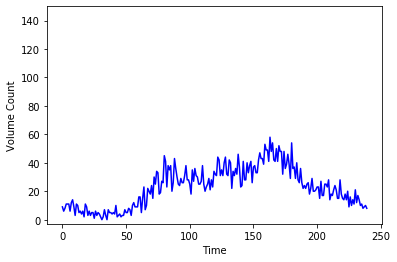

In [8]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]
#print (dataset_original)
#extract State-EB-L_1 series for 18th March
series_18march = dataset_original['Peachtree-SB-L_2'].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(-2.9000000000000004, 150)

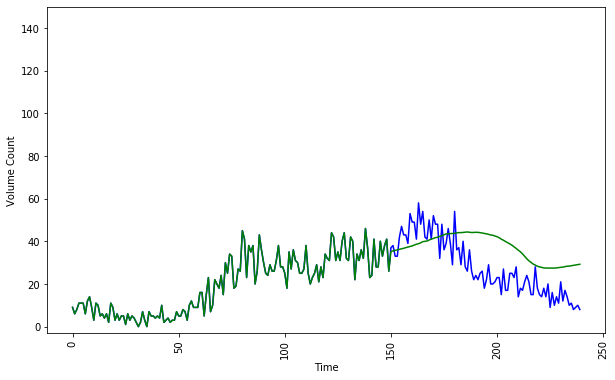

In [9]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 90
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+units_missing] 
sliced_val_times = time_18march[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

In [9]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual-sliced_val_series)
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[ 9.  6.  8. 11. 11. 11.  6. 12. 14.  9.  3. 11. 10.  5.  6.  4.  6.  2.
 11.  9.  3.  6.  3.  5.  5.  1.  6.  3.  5.  4.  2.  0.  2.  7.  3.  0.
  7.  5.  5.  4.  5.  4. 10.  2.  3.  4.  2.  3.  3.  7.  5.  5.  8.  7.
  3. 10. 12.  9.  9.  9. 16. 16.  5. 15. 23.  7. 10. 22. 20. 18. 24. 15.
 30. 25. 34. 33. 18. 19. 27. 26. 45. 41. 23. 38. 35. 38. 20. 26. 43. 36.
 30. 25. 24. 29. 26. 26. 31. 38. 28. 28. 25. 18. 35. 27. 36. 31. 30. 25.
 25. 27. 38. 25. 20. 23. 25. 29. 21. 28. 23. 34. 32. 31. 44. 42. 31. 35.
 31. 40. 44. 32. 31. 42. 40. 22. 34. 31. 36. 32. 46. 37. 23. 24. 41. 28.
 28. 40. 33. 38. 41. 26. 37. 38. 33. 33. 42. 47. 43. 43. 39. 53. 49. 49.
 41. 58. 48. 54. 42. 41. 50. 41. 52. 48. 48. 32. 48. 36. 39. 46. 39. 29.]
[ 9.          6.          8.         11.         11.         11.
  6.         12.         14.          9.          3.         11.
 10.          5.          6.          4.          6.          2.
 11.          9.          3.          6.          3.          5.
  5.     

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_peachtree_sb_l2_univariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_peachtree_sb_l2_univariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

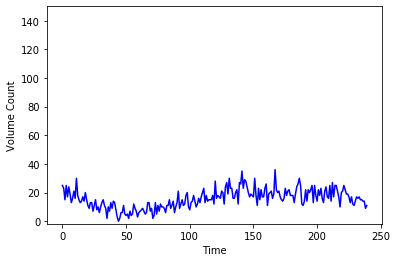

In [9]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 18th March
series_5may = dataset_original['Peachtree-SB-L_2'].values
time_5may = dataset_original['date_time'].values

time_num_5may = [i for i in range(len(series_5may))]

# Plot the 18th March data
plt.plot(time_num_5may, series_5may, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=150)
plt.grid(False)

(-1.8, 150)

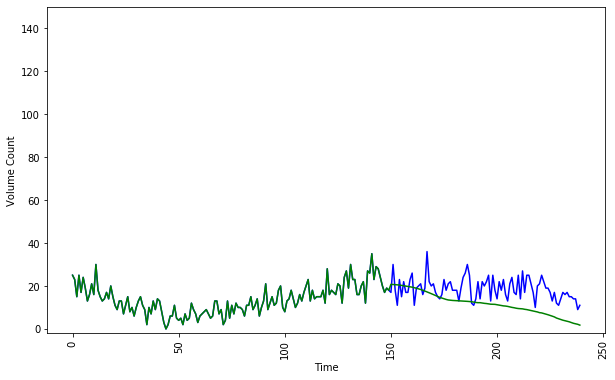

In [19]:
##apply model to the 27th may data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_5may[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 90
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_5may[:slice_val_time+units_missing] 
sliced_val_times = time_5may[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=150)

In [20]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))


# mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean absolute error: "+ str(mae))
# mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
# print ("mean squared error: "+ str(mse))
# rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
# print ("root mean squared error: "+ str(rmse))
# array_of_errors = (sliced_val_actual-sliced_val_series)
# forecast_bias = sum(array_of_errors)
# #print (array_of_errors)
# print ("forecast_bias: "+ str(forecast_bias))
# std_dev_errors = np.std(array_of_errors)
# print ("standard dev of errors: "+ str(std_dev_errors))

[25. 23. 15. 25. 17. 24. 19. 13. 16. 21. 16. 30. 18. 15. 13. 14. 17. 14.
 20. 15. 11.  9. 13. 13.  7. 11. 15.  8. 10.  6. 10. 13. 15. 11.  9.  2.
 10.  7. 13.  9. 14. 13.  8.  3.  0.  2.  6.  6. 11.  5.  4.  5.  2.  7.
  4.  5. 12.  9.  7.  3.  6.  7.  8.  9.  7.  5.  6. 13. 13.  7.  9.  2.
  4. 13.  5. 11.  7. 12. 10. 10.  9.  6. 11. 11. 15.  9. 11. 14.  6. 10.
 13. 21.  9. 12. 15. 11. 12. 18. 20. 10.  8. 13. 14. 18. 14. 10. 12. 16.
 13. 17. 20. 23. 13. 18. 14. 15. 15. 15. 18. 12. 28. 16. 18. 17. 16. 21.
 20. 12. 24. 27. 19. 30. 23. 23. 16. 16. 20. 22. 12. 27. 26. 35. 23. 29.
 28. 24. 20. 17. 19. 18. 17. 30. 18. 11. 23. 15. 22. 17. 17. 23. 26. 11.
 19. 20. 21. 16. 19. 36. 22. 20. 21. 17. 15. 14. 16. 23. 18. 21. 22. 18.
 18. 18. 13. 19. 24. 26. 30. 25. 12. 11. 14. 22. 14. 22. 20. 22. 25. 13.
 25. 18. 14. 22. 18. 23. 16. 13. 21. 24. 17. 16. 25. 14. 27. 17. 25. 25.
 21. 17. 10. 20. 21. 25. 22. 19. 19. 17. 13. 17. 12. 11. 14. 17. 16. 17.
 15. 15. 14. 14.  9. 11.]
[25.         23.         

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_peachtree_sb_l2_univariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_peachtree_sb_l2_univariate_27may.csv")